In [ ]:
# Listing 6.1 Reprising Airbnb NYC dataset

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

url = "https://raw.githubusercontent.com/lmassaron/tabular_datasets/master/AB_NYC_2019.csv"
data = pd.read_csv(url)

excluding_list = ['price', 'id', 'latitude', 'longitude', 'host_id',
                  'last_review', 'name', 'host_name'] #A
low_card_categorical = ['neighbourhood_group', 'room_type'] #B
high_card_categorical = ['neighbourhood'] #C
continuous = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
              'calculated_host_listings_count', 'availability_365']
target_mean = (data["price"] > data["price"].mean()).astype(int) #D
target_median = (data["price"] > data["price"].median()).astype(int) #E
target_multiclass = pd.qcut(data["price"], q=5, labels=False) #F
target_regression = data["price"] #G
categorical_onehot_encoding = OneHotEncoder(handle_unknown='ignore')
categorical_ord_encoding = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
numeric_standardization = Pipeline([('StandardScaler', StandardScaler()),
                                    ('Imputer', SimpleImputer(strategy="constant", fill_value=0))])

column_transform = ColumnTransformer(
    [('low_card_categories', categorical_onehot_encoding, low_card_categorical),
     ('high_card_categories', categorical_ord_encoding, high_card_categorical),
     ('numeric', numeric_standardization, continuous)],
    remainder='drop',
    verbose_feature_names_out=True,
    sparse_threshold=0.0) #H

lm_column_transform = ColumnTransformer(
    [('low_card_categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_standardization, continuous),
    ],
    remainder='drop',
    verbose_feature_names_out=True,
    sparse_threshold=0.0) #I

target_median = (data["price"] > data["price"].median()).astype(int)

#A list of columns to exclude from the analysis
#B Categorical features to be one-hot encoded
#C Categorical features to be ordinally encoded
#D Unbalanced binary target
#E Balanced binary target
#F Multiclass target with 5 classes
#G Regression target
#H Data transformation for tree-based ensembles
#I Data transformation for linear models, using a sparse matrix

In [ ]:
# Listing 6.2 Multivariate imputation

from sklearn.experimental import enable_iterative_imputer #A
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor

Xm = data[continuous].copy() #B
missing_percentage = 0.05
np.random.seed(0)
mask = np.random.rand(*Xm.shape) < missing_percentage #C
Xm[mask] = np.nan

simple_imputer = SimpleImputer()
Xm_si = simple_imputer.fit_transform(Xm) #D

rf = RandomForestRegressor(random_state=0, n_jobs=-1) #E
multivariate_imputer = IterativeImputer(estimator=rf, max_iter=1, tol=0.01) #F
Xm_mi = multivariate_imputer.fit_transform(Xm)

mae = pd.DataFrame({"simple": np.mean(np.abs(data[continuous] - Xm_si), axis=0),
                 	"multivariate": np.mean(np.abs(data[continuous] - Xm_mi), axis=0)},
                	index = continuous) #G
print(mae)

#A IterativeImputer is still experimental and under improvement in Scikit-learn
#B Select only the continuous features
#C Randomly cancel 5% of data
#D Imputing missing data using the mean
#E Instantiating RandomForest as estimator for imputations
#F max_iter and tol are the stopping criteria
#G Comparing the MAE for the simple and the multivariate imputation

                                  simple  multivariate
minimum_nights                  0.347355      0.260156
number_of_reviews               1.327776      0.858506
reviews_per_month               0.057980      0.036876
calculated_host_listings_count  0.579423      0.368567
availability_365                6.025748      4.622640


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# Listing 6.3 Creating a high cardinality categorical feature

def bin_2_cat(feature, bins=100):
	min_value = feature.min()
	bin_size = (feature.max() - min_value) / bins
	return ((feature - min_value) / bin_size).astype(int) # A

data['coordinates'] = bin_2_cat(data['latitude']) * 1000 + bin_2_cat(data['longitude']) #B
high_card_categorical += ['coordinates']

print(data[high_card_categorical].nunique()) #C

#A continuous values are divided into numbered bins
#B latitude bin values are multiplied by 1,000 and then summed to longitude ones
#C print unique values for each high cardinality categorical feature

neighbourhood     221
coordinates      2259
dtype: int64


In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Listing 6.4 Using target encoding in the pipeline

from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import accuracy_score, make_scorer

target_encoder = TargetEncoder(cols=high_card_categorical, # A
                               smoothing=0.5) # B
accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
xgb = XGBClassifier(booster='gbtree',
                	objective='reg:logistic',
                	n_estimators=300,
                	max_depth=4,
                	min_child_weight=3)

column_transform = ColumnTransformer(
	[('low_card_categories', categorical_onehot_encoding, low_card_categorical),
 	('high_card_categories', target_encoder, high_card_categorical), # C
 	('numeric', numeric_standardization, continuous)],
	remainder='drop',
	verbose_feature_names_out=True,
	sparse_threshold=0.0)

model_pipeline = Pipeline(
	[('processing', column_transform),
 	('model', xgb)])

cv_scores = cross_validate(estimator=model_pipeline,
                       	X=data,
                       	y=target_median,
                       	scoring=accuracy,
                       	cv=cv,
                       	return_train_score=True,
                       	return_estimator=True)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
  	f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs")

#A When setting the target encoder, we specify all the columns to encoded
#B We provide a smoothing value to blend prior and posterior probabilities
#C The target encoder is enclosed into the column transformer

0.840 (0.003) fit: 11.87 secs pred: 0.08 secs


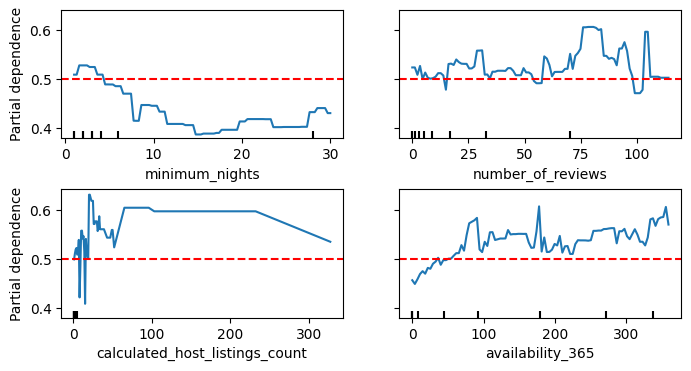

In [ ]:
# Listing 6.5 Partial Dependence Plot

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

xgb = XGBClassifier(booster='gbtree',
                    objective='reg:logistic',
                    n_estimators=300,
                    max_depth=4,
                    min_child_weight=3)

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('xgboost', xgb)])

model_pipeline.fit(X=data, y=target_median)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.2) #A

PartialDependenceDisplay.from_estimator(model_pipeline,
                                        X=data,
                                        kind='average', #B
                                        features=['minimum_nights',
                                                  'number_of_reviews',
                                                  'calculated_host_listings_count',
                                                  'availability_365'], #C
                                       ax=axes)

for ax in axes.flatten():
    ax.axhline(y=0.5, color='red', linestyle='--') #D

plt.show()

#A Creating a panel of plots and setting their spacing
#B Given the model and the data, we require for an average estimate of the relationship of the features with the target
#C A list defining the features involved in the analysis
#D Plotting the decision boundary of 0.5 for classification

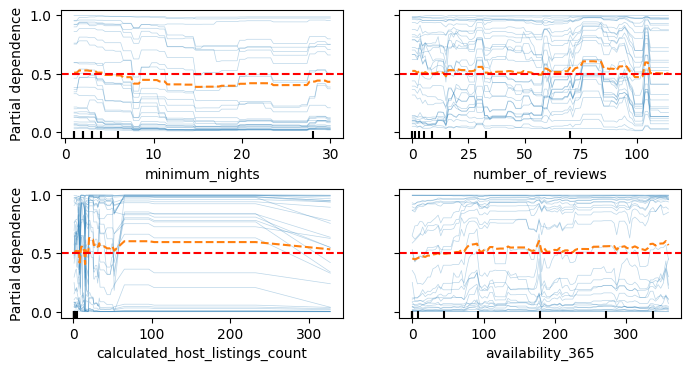

In [ ]:
# Listing 6.6 ICE plots

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

PartialDependenceDisplay.from_estimator(model_pipeline,
                                        X=data,
                                        kind='both', #A
                                        subsample=30, #B
                                        features=['minimum_nights',
                                                  'number_of_reviews',
                                                  'calculated_host_listings_count',
                                                  'availability_365'],
                                       ax=axes)

for ax in axes.flatten():
    ax.axhline(y=0.5, color='red', linestyle='--')
    ax.legend().set_visible(False)

plt.show()

#A by specifying “both”, you require both the PDP and ICE curves
#B specifying how many single curves to sample and represent


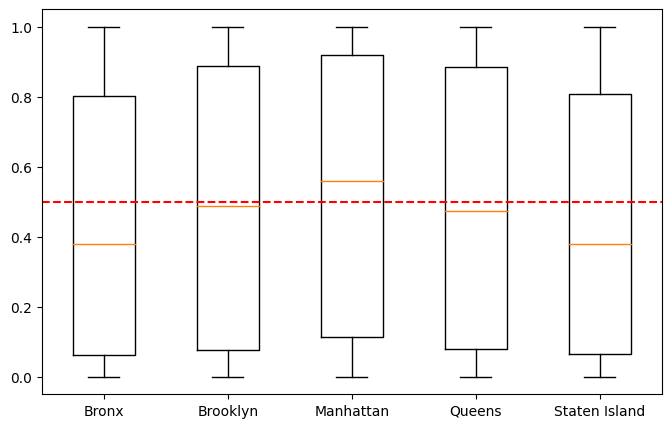

In [ ]:
# Listing 6.7 Partial Dependence Plot for binary features

from sklearn.inspection import partial_dependence #A
import matplotlib.pyplot as plt

pd_ice = partial_dependence(model_pipeline, X=data,
                            features=['neighbourhood_group'],
                            kind='both')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
labels = np.ravel(pd_ice['values'])
plt.boxplot(pd_ice["individual"].squeeze(), labels=labels) #B
ax.axhline(y=0.5, color='red', linestyle='--') #C
plt.show()

#A partial_dependence computes the curves values
#B representing the mean value (PDP) and ICE values in a box plot
#C Highlighting the decision threshold

In [ ]:
!pip install xgbfir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 3.9 MB/s eta 0:00:00


high_card_categories__coordinates|low_card_categories__room_type_Entire home/apt
high_card_categories__neighbourhood|low_card_categories__room_type_Entire home/apt
high_card_categories__coordinates|high_card_categories__coordinates
high_card_categories__coordinates|high_card_categories__neighbourhood
high_card_categories__neighbourhood|numeric__availability_365
high_card_categories__coordinates|numeric__availability_365
high_card_categories__coordinates|numeric__minimum_nights
high_card_categories__neighbourhood|numeric__minimum_nights
high_card_categories__coordinates|numeric__calculated_host_listings_count
high_card_categories__coordinates|numeric__reviews_per_month


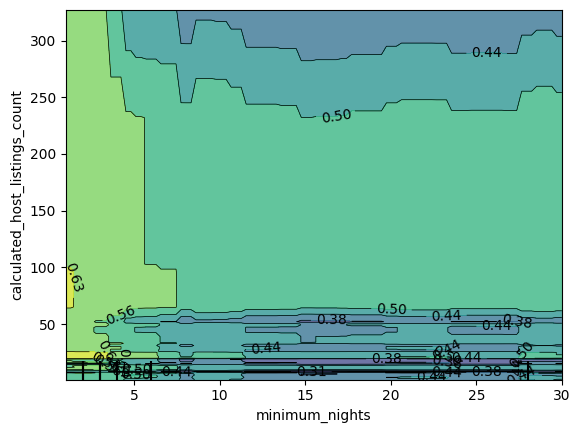

In [ ]:
# Listing 6.8 Discovering interactions by XGBFIR

import xgbfir
xgbfir.saveXgbFI(model_pipeline['xgboost'],
                 feature_names=model_pipeline['processing'].get_feature_names_out(),
                 OutputXlsxFile='fir.xlsx') #A
fir = pd.read_excel('fir.xlsx', sheet_name='Interaction Depth 1') #B
result = fir[["Interaction", "Gain"]].sort_values(by="Gain",
                                            ascending=False).head(10).round(2) #C
for index, row in result.iterrows():
    print(f"{row['Interaction']}")

PartialDependenceDisplay.from_estimator(model_pipeline,
                                        X=data,
                                        kind='average',
                                        features=[('minimum_nights',
                                                  'calculated_host_listings_count')]) #D

#A xgbfir saves its results as an MS Excel file
#B reloading xgbfir results
#C sorting the results in order to highlight the most important interactions by split gains
#B PartialDepenceDisplay plots a contour map of two feature provided in a tuple

In [ ]:
# Listing 6.9 Stability Selection

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

lambda_grid=np.logspace(-4, -1, 10) #A
sparse_coef = list()

for modeling_c in lambda_grid:
    estimator = LogisticRegression(solver='liblinear', penalty='l1', C=modeling_c) #B
    model = BaggingClassifier(estimator, n_estimators=100, bootstrap=True) #C
    model_pipeline = Pipeline(
        [('processing', lm_column_transform),
         ('standardize', StandardScaler()), #D
         ('modeling', model)])
    model_pipeline.fit(data, target_median)
    sparse_coef += [estimator.coef_.ravel() for estimator in model_pipeline["modeling"].estimators_]

epsilon = 1e-2 #E
threshold = 0.5 #F

non_zero = (np.abs(sparse_coef) > epsilon).mean(axis=0)
feature_names = model_pipeline["processing"].get_feature_names_out()
print(non_zero)
print(feature_names[non_zero > threshold])

#A Define a grid of values for L1 penalty
#B Logistic regression with L1 penalty
#C Bagging multiple estimators based on bootstrapped data
#D Standardization makes all the coefficients comparable, no matter the scale
#E Epsilon threshold that signals coefficients relevant for the problem
#F Frequency threshold for feature selection

[0.629 0.    0.9   0.7   0.598 1.    0.    0.599 0.585 0.583 0.445 0.51
 0.7  ]
['low_card_categories__neighbourhood_group_Bronx'
 'low_card_categories__neighbourhood_group_Manhattan'
 'low_card_categories__neighbourhood_group_Queens'
 'low_card_categories__neighbourhood_group_Staten Island'
 'low_card_categories__room_type_Entire home/apt'
 'low_card_categories__room_type_Shared room' 'numeric__minimum_nights'
 'numeric__number_of_reviews' 'numeric__calculated_host_listings_count'
 'numeric__availability_365']


In [ ]:
! pip install Boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.2 MB/s eta 0:00:00


In [ ]:
# Listing 6.10 Boruta selection

from xgboost import XGBClassifier
from boruta import BorutaPy

xgb = XGBClassifier(booster='gbtree',
                    objective='reg:logistic',
                    n_estimators=300,
                    max_depth=4,
                    min_child_weight=3)

X = column_transform.fit_transform(data, target_median) #A
boruta_selector = BorutaPy(estimator=xgb, n_estimators='auto', verbose=2) #B
boruta_selector.fit(X, target_median) #C
selected_features = boruta_selector.support_ #D
selected_data = column_transform.get_feature_names_out()[selected_features]
print(selected_data)

#A transforming your data, Boruta doesn’t work with pipelines
#B Boruta instantiation with your estimator and some parameters
#C fitting on data
#D Boolean vector for selected features

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	0
I

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(boosting_type='gbdt',
                      n_estimators=300,
                      max_depth=4,
                      min_child_samples=3)

boruta_selector = BorutaPy(estimator=lgbm, n_estimators='auto', verbose=2) #A
boruta_selector.fit(X, target_median)
selected_features = boruta_selector.support_
selected_data = column_transform.get_feature_names_out()[selected_features]
print(selected_data)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	7
['low_card_categories__room_type_Entire home/apt'
 'high_card_categories__neighbourhood' 'high_card_categories__coordinates'
 'numeric__minimum_nights' 'numeric__number_of_reviews'
 'numeric__reviews_per_month' 'numeric__calculated_host_listings_count'
 'numeric__availability_365']


In [ ]:
# Listing 6.11 Forward selection

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, make_scorer
from xgboost import XGBClassifier

xgb = XGBClassifier(booster='gbtree',
                    objective='reg:logistic',
                    n_estimators=300,
                    max_depth=4,
                    min_child_weight=3)

cv = KFold(5, shuffle=True, random_state=0) #A
accuracy = make_scorer(accuracy_score) #B
X = column_transform.fit_transform(data, target_median)
selector = SequentialFeatureSelector(estimator=xgb,
                                     n_features_to_select="auto",
                                     tol=0.0001, #C
                                     direction="forward", #D
                                     scoring=accuracy,
                                     cv=cv)
selector.fit(X, target_median)
selected_features = selector.support_ #E
selected_data = column_transform.get_feature_names_out()[selected_features]
print(selected_data)

#A Cross-validation strategy
#B Evaluation metric
#C Tolerance threshold for the stopping rule
#D Direction of the selection
#E Boolean vector of selected features

['low_card_categories__neighbourhood_group_Bronx'
 'low_card_categories__room_type_Entire home/apt'
 'low_card_categories__room_type_Shared room'
 'high_card_categories__neighbourhood' 'high_card_categories__coordinates'
 'numeric__minimum_nights' 'numeric__number_of_reviews'
 'numeric__reviews_per_month' 'numeric__calculated_host_listings_count'
 'numeric__availability_365']


In [ ]:
selector = SequentialFeatureSelector(estimator=xgb,
                                     n_features_to_select="auto",
                                     tol=0.0001,
                                     direction="backward",
                                     scoring=accuracy,
                                     cv=cv)
selector.fit(X, target_median)
selected_features = selector.support_
selected_data = column_transform.get_feature_names_out()[selected_features]
print(selected_data)

In [ ]:
# Listing 6.12 Grid search

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
model = LogisticRegression(solver="saga", max_iter=5_000)

model_pipeline = Pipeline(
    [('processing', lm_column_transform),
     ('model', model)])

search_grid = [
    {"model__penalty": [None]},
    {"model__penalty": ["l1", "l2"], "model__C": np.logspace(-4, 4, 10)},
    {"model__penalty": ["elasticnet"], "model__C": np.logspace(-4, 4, 10),
     "model__l1_ratio": [.1, .3, .5, .7, .9, .95, .99]},
] #A

search_func = GridSearchCV(estimator=model_pipeline, #B
                           param_grid=search_grid,
                           scoring=accuracy,
                           n_jobs=-1,
                           cv=cv)

search_func.fit(X=data, y=target_median)
print (search_func.best_params_) #C
print (search_func.best_score_) #D

#A defining the search grid
#B instantiating the grid search
#C the .best_params_ attribute returns the best chosen parameters
#D the .best_score_ attribute returns the best validation score obtained by the procedure

In [ ]:
# Listing 6.13 Random search

from sklearn.utils.fixes import loguniform
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)

xgb = XGBClassifier(booster='gbtree', objective='reg:logistic')
model_pipeline = Pipeline([('processing', column_transform), ('xgb', xgb)]) #A

search_dict = { #B
    'xgb__n_estimators': np.arange(100, 2000, 100),
    'xgb__learning_rate': loguniform(0.01, 1),
    'xgb__max_depth': np.arange(1, 8),
    'xgb__subsample': np.arange(0.1, 0.9, 0.05),
    'xgb__colsample_bytree': np.arange(0.1, 0.9, 0.05),
    'xgb__reg_lambda': loguniform(1e-9, 100),
    'xgb__reg_alpha': loguniform(1e-9, 100)
}

search_func = RandomizedSearchCV(estimator=model_pipeline,
                                 param_distributions=search_dict,
                                 n_iter=60, #C
                                 scoring=accuracy,
                                 n_jobs=1, #D
                                 cv=cv,
                                 random_state=0)

search_func.fit(X=data, y=target_median)
print (search_func.best_params_) #E
print (search_func.best_score_) #F

#A pipeline containing both data transformation and
#B search space containing references to hyperparameters in xgb section of the pipeline
#C the number of random tests to be performed
#D if your machine learning algorithm is multithread or multiprocessor, just set n_jobs to one
#E printing the best parameters found
#F printing the best score obtained by the specified cross validation procedure

In [ ]:
# Listing 6.14 Halving random search

from sklearn.experimental import enable_halving_search_cv #A
from sklearn.model_selection import HalvingRandomSearchCV

search_func = HalvingRandomSearchCV(estimator=model_pipeline,
                                	param_distributions=search_dict,
                                	resource='n_samples',#B
                                	n_candidates=20,#C
                                	factor=3,#D
                                	min_resources=int(len(data) * 0.3), #E
                                	max_resources=len(data), #F
                                	scoring=accuracy,
                                	n_jobs=1,
                                	cv=cv,
                                	random_state=0)

search_func.fit(X=data, y=target_median)
print (search_func.best_params_)
print (search_func.best_score_)

#A Still experimental in Scikit-learn at the time of the writing (expect changes in future versions)
#B the scarce resource you leverage, samples are both connected to running time and computations
#C the initial candidates
#D the factor you reduce the candidates at each round
#E the minimum level of the resource you start from
#E the maximum level of the resource you end the process with

In [ ]:
!pip install optuna

In [ ]:
# Listing 6.15 Bayesian search with Optuna

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
    } #A

    xgb = XGBClassifier(booster='gbtree', objective='reg:logistic', **params) #B
    model_pipeline = Pipeline([('processing', column_transform), ('xgb', xgb)])
    accuracy = make_scorer(accuracy_score)
    cv = KFold(5, shuffle=True, random_state=0)

    cv_scores = cross_validate(estimator=model_pipeline,
                               X=data,
                               y=target_median,
                               scoring=accuracy,
                               cv=cv) #C

    cv_accuracy = np.mean(cv_scores['test_score'])
    return cv_accuracy #D

study = optuna.create_study(direction="maximize") #E
study.optimize(objective, n_trials=60) #F
print(study.best_value)
print(study.best_params)

#A hyperparameters definition using methods from trial
#B values choose by Optuna to be tested are passed to the model
#C the evaluation is done by a cross-validation procedure
#D the objective function just returns a score
#E the Optuna study is instantiated by telling if we aim to minimize or maximize the score
#F the optimization is run by providing the objective function and the number of trials

In [ ]:
sqlite_db = "sqlite:///sqlite.db" #A
study_name = "optimize_xgboost" #B
study = optuna.create_study(storage=sqlite_db, study_name=study_name,
                            direction="maximize", load_if_exists=True) #C
study.optimize(objective, n_trials=60)

print(study.best_params)
print(study.best_value)

#A SQLite database definition
#B Definition of the name of the study
#C load_if_exists=True implies to reuse any previous experiment, if found


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
# Listing 6.16 Extracting XGBoost tree structure

import json
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_tree
from collections import namedtuple

xgb = XGBClassifier(booster='gbtree',
                	objective='reg:logistic',
                	n_estimators=10,
                	max_depth=3) #A

model_pipeline = Pipeline(
	[('processing', column_transform),
 	('xgboost', xgb)]) #B

model_pipeline.fit(X=data, y=target_median)
model = model_pipeline["xgboost"]
tree_info = model.get_booster().dump_model("xgb_model.json",
                                       	with_stats=True,
                                       	dump_format="json") #C

fig, ax = plt.subplots(figsize=(12, 15), dpi=300)
ax = plot_tree(model, num_trees=0, ax=ax) #D
plt.show()

with open("xgb_model.json", "r") as f:
	json_model = json.loads(f.read()) #E

print(f"Number of trees: {len(json_model)}")
tree_structure = json_model[0] #F

Split = namedtuple("SplitNode", "feature origin gain count threshold")
Leaf = namedtuple("LeafNode", "index origin count")

def extract_xgb_node_info(tree):
	return [tree['split'], tree['origin'], tree['gain'],
        	tree['cover'], tree['split_condition']] #G

def extract_xgb_leaf_info(tree):
	return [tree['nodeid'], tree['origin'], tree['cover']] #H

def traverse_xgb_tree(tree): #I
  if not 'origin' in tree:
    tree['origin'] = "="
  if not 'children' in tree:
    return [[Leaf(*extract_xgb_leaf_info(tree))]]
  left_branch = tree['children'][0]
  right_branch = tree['children'][1]
  left_branch['origin'] = '<'
  right_branch['origin'] = '>='
  left_paths = traverse_xgb_tree(left_branch)
  right_paths = traverse_xgb_tree(right_branch)
  node_info = [Split(*extract_xgb_node_info(tree))]
  return [node_info + path for path in left_paths + right_paths]

paths = traverse_xgb_tree(tree_structure)

print(f"Number of paths on tree: {len(paths)}")
print("Path 0:", paths[0])

#A simple XGBoost classifier limited to 10 estimators and trees of 3 levels
#B extracting the XGBoost model from the pipeline
#C saving the model structure from the booster, the core of the XGBoost model
#D plotting the structure of the decision tree
#E the json structure is retrieved from disk
#F picking just the first tree
#G function to return node information
#H function to return leaf information
#I function to traverse the entire tree structure

In [ ]:
# Listing 6.17 Extracting LightGBM tree structure

from lightgbm import LGBMClassifier, plot_tree

lgbm = LGBMClassifier(boosting_type='gbdt',
                      n_estimators=10,
                      max_depth=3)

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('lightgbm', lgbm)])

model_pipeline.fit(X=data, y=target_median)
model = model_pipeline["lightgbm"]

tree_info = model._Booster.dump_model()["tree_info"] #A
tree_structure = tree_info[0]['tree_structure'] #B
plot_tree(booster=model._Booster, tree_index=0, dpi=600) #C

Split = namedtuple("SplitNode", "feature origin decision_type threshold gain count")
Leaf = namedtuple("LeafNode", "index origin count value")

def extract_lgbm_node_info(tree): #D
    return [tree['split_feature'], tree['origin'], tree['decision_type'],
            tree['threshold'], tree['split_gain'], tree['internal_count']]

def extract_lgbm_leaf_info(tree): #E
    return [tree['leaf_index'], tree['origin'], tree['leaf_count'], tree['leaf_value']]

def traverse_lgbm_tree(tree): #F
    if not 'origin' in tree:
        tree['origin'] = ""
    if not 'left_child' in tree and not 'right_child' in tree:
        return [[Leaf(*extract_lgbm_leaf_info(tree))]]
    left_branch = tree['left_child']
    right_branch = tree['right_child']
    left_branch['origin'] = 'yes'
    right_branch['origin'] = 'no'
    left_paths = traverse_lgbm_tree(left_branch)
    right_paths = traverse_lgbm_tree(right_branch)
    node_info = [Split(*extract_lgbm_node_info(tree))]
    return [node_info + path for path in left_paths + right_paths]

paths = traverse_lgbm_tree(tree_structure)
print(paths[0])

#A The structure of all the trees is directly extracted from the booster of the LightGBM model
#B We extract the structure of the first tree
#C Plotting the tree structure using the function provided
#D function to return node information
#E function to return leaf information
#F function to traverse the entire tree structure

In [ ]:
!pip install tl2cgen treelite treelite_runtime

In [ ]:
# Listing 6.18 XGBoost prediction speedup by treelite

import treelite
import treelite_runtime
import tl2cgen

model.save_model("./xgb_model.json") #A
treelite_model = treelite.Model.load("./xgb_model.json", model_format="xgboost_json") #B
tl2cgen.generate_c_code(treelite_model, dirpath="./", params={"parallel_comp": 4})
tl2cgen.export_lib(treelite_model, toolchain="gcc", libpath="./xgb_model.so",
                   params={"parallel_comp": 4})

predictor = tl2cgen.Predictor("./xgb_model.so")
X = model_pipeline["processing"].transform(data) #D
dmat = tl2cgen.DMatrix(X) #E
predictor.predict(dmat)

#A saving the model in json format, containing all the tree structures
#B the model is reloaded in treelite data structure
#C treelite generates the c code and exports the libraries connected to it
#D we separately process the features
#E the features are furthermore transformed into a DMatrix structure

In [ ]:
!pip install leaves

In [ ]:
# Listing 6.19 LightGBM prediction speedup by lleaves

import lleaves

model.booster_.save_model('lgb_model.txt') #A

llvm_model = lleaves.Model(model_file="lgb_model.txt") #B
llvm_model.compile() #C
X = model_pipeline["processing"].transform(data) #D
llvm_model.predict(X)

#A the tree structures is saved in textual form
#B the tree structures are loaded into lleaves
#C compiling command
#D features are preprocessed separately